### TODO
- add reconstruction
- add validation
- add saving (?) or fix saving to be pickle-able (add warning to __get_state__ that keras embeddings are not pickleable)
- add non-parametric embedding

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load dataset

In [4]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

### modules

In [5]:
import numpy as np
import tensorflow as tf
from umap import UMAP
from warnings import warn
from umap.umap_ import make_epochs_per_sample

In [6]:
def get_graph_elements(graph_, n_epochs):
    """
    gets elements of graphs, weights, and number of epochs per edge

    Parameters
    ----------
    graph_ : [type]
        umap graph of probabilities
    n_epochs : int
        maximum number of epochs per edge

    Returns
    -------
    graph [type]
        umap graph
    epochs_per_sample np.array
        number of epochs to train each sample for
    head np.array
        edge head
    tail np.array
        edge tail
    weight np.array
        edge weight
    n_vertices int
        number of verticies in graph
    """
    ### should we remove redundancies () here??
    # graph_ = remove_redundant_edges(graph_)

    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices

In [7]:
def convert_distance_to_probability(distances, a, b):
    """ convert distance representation into probability, 
        as a function of a, b params
    """
    return 1.0 / (1.0 + a * distances ** (2 * b))

In [8]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    """
    Compute cross entropy between low and high probability

    Parameters
    ----------
    probabilities_graph : [type]
        high dimensional probabilities
    probabilities_distance : [type]
        low dimensional probabilities
    EPS : [type], optional
        offset to to ensure log is taken of a positive number, by default 1e-4
    repulsion_strength : float, optional
        strength of repulsion between negative samples, by default 1.0

    Returns
    -------
    attraction_term: tf.float32
        attraction term for cross entropy loss
    repellant_term: tf.float32
        repellant term for cross entropy loss
    cross_entropy: tf.float32
        cross entropy umap loss
    
    """
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [9]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength=1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(
            embed_to_from, num_or_size_splits=2, axis=1
        )

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
        )

        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [10]:
#@tf.function
def umap_loss__(embed_to_from, batch_size, negative_sample_rate, _a, _b, repulsion_strength=1.0):
    
    # split out to/from
    embedding_to, embedding_from = tf.split(
        embed_to_from, num_or_size_splits=2, axis=1
    )

    # get negative samples
    embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
    repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
    embedding_neg_from = tf.gather(
        repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
    )

    #  distances between samples (and negative samples)
    distance_embedding = tf.concat(
        [
            tf.norm(embedding_to - embedding_from, axis=1),
            tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
        ],
        axis=0,
    )

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(
        distance_embedding, _a, _b
    )

    # set true probabilities based on negative sampling
    probabilities_graph = tf.concat(
        [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
    )

    # compute cross entropy
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph,
        probabilities_distance,
        repulsion_strength=repulsion_strength,
    )
    return tf.cast(tf.reduce_mean(ce_loss), tf.float32)



In [11]:
from umap.spectral import spectral_layout
from sklearn.utils import check_random_state


def init_embedding_from_graph(
    _raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"
):
    """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
    if random_state is None:
        random_state = check_random_state(None)
    
    if isinstance(init, str) and init == "random":
        embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], n_components)
        ).astype(np.float32)
    elif isinstance(init, str) and init == "spectral":
        # We add a little noise to avoid local minima for optimization to come

        initialisation = spectral_layout(
            _raw_data,
            graph,
            n_components,
            random_state,
            metric=metric,
            metric_kwds=_metric_kwds,
        )
        expansion = 10.0 / np.abs(initialisation).max()
        embedding = (initialisation * expansion).astype(
            np.float32
        ) + random_state.normal(
            scale=0.0001, size=[graph.shape[0], n_components]
        ).astype(
            np.float32
        )

    else:
        init_data = np.array(init)
        if len(init_data.shape) == 2:
            if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                tree = KDTree(init_data)
                dist, ind = tree.query(init_data, k=2)
                nndist = np.mean(dist[:, 1])
                embedding = init_data + random_state.normal(
                    scale=0.001 * nndist, size=init_data.shape
                ).astype(np.float32)
            else:
                embedding = init_data

    return embedding

In [12]:
def prepare_networks(
    encoder, decoder, n_components, dims, n_data, parametric_embedding, init_embedding
):

    if parametric_embedding:
        if encoder is None:
            encoder = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=dims),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=n_components, name="z"),
                ]
            )
    else:
        embedding_layer = tf.keras.layers.Embedding(
            n_data, n_components, input_length=1
        )
        embedding_layer.build(input_shape=(1,)) 
        embedding_layer.set_weights([init_embedding])
        encoder = tf.keras.Sequential([embedding_layer])

    return encoder, decoder

In [13]:
def construct_edge_dataset(
    X,
    graph_,
    n_epochs,
    batch_size,
    max_sample_repeats_per_epoch,
    parametric_embedding,
    parametric_decoding,
):
    """ Construct a tf.data.Dataset of edges, sampled by edge weight.
    """

    def gather_X(edge_to, edge_from):
        return (tf.gather(X, edge_to), tf.gather(X, edge_from)), 0
    def nonparametric_gather_X(edge_to, edge_from):
        return (tf.expand_dims(edge_to, -1), tf.expand_dims(edge_from, -1)), tf.cast([0.0], tf.float32)

    # get data from graph
    graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
        graph_, n_epochs
    )

    # number of elements per batch for embedding
    if batch_size is None:
        # batch size can be larger if its just over embeddings
        if (parametric_embedding == False) & (parametric_decoding is None):
            batch_size = np.min([n_vertices, 60000])
        else:
            batch_size = np.min([n_vertices, 1000])

    edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
        np.repeat(tail, epochs_per_sample.astype("int")),
    )

    # shuffle edges
    shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
    edges_to_exp = edges_to_exp[shuffle_mask]
    edges_from_exp = edges_from_exp[shuffle_mask]

    # create edge iterator
    edge_dataset = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
    edge_dataset = edge_dataset.repeat()
    edge_dataset = edge_dataset.shuffle(10000)
    if parametric_embedding:
        edge_dataset = edge_dataset.map(
            gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    else:
        edge_dataset = edge_dataset.map(
            nonparametric_gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    edge_dataset = edge_dataset.batch(batch_size, drop_remainder=True)
    edge_dataset = edge_dataset.prefetch(10)
    return edge_dataset, batch_size, len(edges_to_exp)

In [21]:
class ParametricUMAP(UMAP):
    def __init__(
        self,
        optimizer=None,
        batch_size=None,
        dims=None,
        encoder=None,
        decoder=None,
        parametric_embedding=True,
        parametric_decoding=False,
        autoencoder_decoding=False,
        max_sample_repeats_per_epoch=None,
        loss_report_frequency=1,
        n_training_epochs=1,
        **kwargs
    ):
        """ Parametric UMAP subclassing UMAP-learn, based on keras/tensorflow.
        There is also a non-parametric implementation contained within to compare 
        with the base non-parametric implementation.
        """
        super().__init__(**kwargs)

        # add to network
        self.dims = dims  # if this is an image, we should reshape for network
        self.encoder = encoder  # neural network used for embedding
        self.decoder = decoder  # neural network used for decoding
        self.parametric_embedding = (
            parametric_embedding  # nonparametric vs parametric embedding
        )
        self.parametric_decoding = parametric_decoding
        self.max_sample_repeats_per_epoch = max_sample_repeats_per_epoch
        self.batch_size = batch_size
        self.loss_report_frequency = (
            loss_report_frequency  # how many times per epoch to report loss in keras
        )
        # how many epochs to train for (different than n_epochs which is specific to each sample)
        self.n_training_epochs = n_training_epochs
        # set optimizer
        if optimizer is None:
            if parametric_embedding:
                # Adam is better for parametric_embedding
                self.optimizer = tf.keras.optimizers.Adam(1e-3)
            else:
                # Adadelta is better for direct embedding
                self.optimizer = tf.keras.optimizers.Adadelta(50)
        else:
            self.optimizer = optimizer

    def define_model(self):
        """ Define the model in keras
        """

        # inputs
        if self.parametric_embedding:
            to_x = tf.keras.layers.Input(shape=self.dims, name="to_x")
            from_x = tf.keras.layers.Input(shape=self.dims, name="from_x")
            embedding_to = self.encoder(to_x)
            embedding_from = self.encoder(from_x)
        else:
            to_x = tf.keras.layers.Input(shape=(1), name="to_x")
            from_x = tf.keras.layers.Input(shape=(1), name="from_x")
            embedding_to = self.encoder(to_x)[:, -1, :]
            embedding_from = self.encoder(from_x)[:, -1, :]
        
            print(embedding_to)
        # batch_size, negative_sample_rate, _a, _b, repulsion_strength
        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, self.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, self.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, tf.cast(self._a, tf.float32), tf.cast(self._b, tf.float32)
        )

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(self.batch_size), tf.zeros(self.batch_size * self.negative_sample_rate)], axis=0,
        )

        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self.repulsion_strength,
        )
        
        umap_loss = tf.reduce_mean(ce_loss)
        
        
        
        # create model
        self.parametric_model = tf.keras.Model(
            inputs=[to_x, from_x], outputs={"umap": umap_loss},
        )

    def compile_model(self):

        self.parametric_model.compile(
            optimizer=self.optimizer,
            loss={
                # "reconstruction": tf.keras.losses.BinaryCrossentropy(),
                "umap": "mae",
            },
            loss_weights={"umap": 1.0},
        )

    def _fit_embed_data(self, X, n_epochs, init, random_state):

        # get dimensionality of dataset
        if self.dims is None:
            self.dims = [np.shape(X)[-1]]
        else:
            # reshape data for network
            if len(self.dims) > 1:
                X = np.reshape(X, [len(X)] + list(self.dims))

        self.n_data = len(X)

        # get dataset of edges
        edge_dataset, self.batch_size, n_edges = construct_edge_dataset(
            X,
            self.graph_,
            self.n_epochs,
            self.batch_size,
            self.max_sample_repeats_per_epoch,
            self.parametric_embedding,
            self.parametric_decoding,
        )

        if not self.parametric_embedding:
            init_embedding = init_embedding_from_graph(
                X,
                self.graph_,
                self.n_components,
                self.random_state,
                self.metric,
                self._metric_kwds,
                init="spectral",
            )

        # create encoder and decoder model
        self.encoder, self.decoder = prepare_networks(
            self.encoder,
            self.decoder,
            self.n_components,
            self.dims,
            self.n_data,
            self.parametric_embedding,
            init_embedding,
        )

        # create the model
        self.define_model()
        self.compile_model()

        # report every loss_report_frequency subdivision of an epochs
        steps_per_epoch = int(n_edges / self.batch_size / self.loss_report_frequency)

        # create embedding
        self._history = self.parametric_model.fit(
            edge_dataset,
            epochs=self.loss_report_frequency * self.n_training_epochs,
            steps_per_epoch=steps_per_epoch,
            max_queue_size=100,
        )

        embedding = self.encoder.predict(X, verbose=True)

        return embedding, {}

In [22]:
dims = (28,28, 1)
n_components = 2

In [23]:
model = ParametricUMAP(
    
    parametric_embedding=False, dims=dims, loss_report_frequency=5, n_training_epochs=5,
    verbose=True
)

In [24]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_train_flat = X_train_flat[:1000]

In [25]:
embedding = model.fit(X_train_flat)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ParametricUMAP(autoencoder_decoding=None, dims=(28, 28, 1),
               loss_report_frequency=5, n_training_epochs=5,
               optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7fdb285b1c50>,
               parametric_embedding=False)
Construct fuzzy simplicial set
Thu Aug 13 15:26:49 2020 Finding Nearest Neighbors
Thu Aug 13 15:26:49 2020 Finished Nearest Neighbor Search
Thu Aug 13 15:26:49 2020 Construct embedding
Tensor("strided_slice_1:0", shape=(None, 2), dtype=float32)
Epoch 1/25
23/23 [==============================] - 0s 20ms/step - loss: 0.3171
Epoch 2/25
23/23 [==============================] - 1s 22ms/step - loss: 0.2989
Epoch 3/25
23/23 [==============================] - 1s 22ms/step - loss: 0.2853
Epoch 4/25
23/23 [==============================] - 0s 22ms/step - loss: 0.2780
Epoch 5/25
23/23 [==============================] - 1s 22ms/step - loss: 0.2704
Epoch 6/25
23/23 [==============================] - 1s 22ms/step - loss: 0.2676
Epo

KeyboardInterrupt: 

In [190]:
z = model.encoder.trainable_variables[0].numpy()

In [191]:
import matplotlib.pyplot as plt

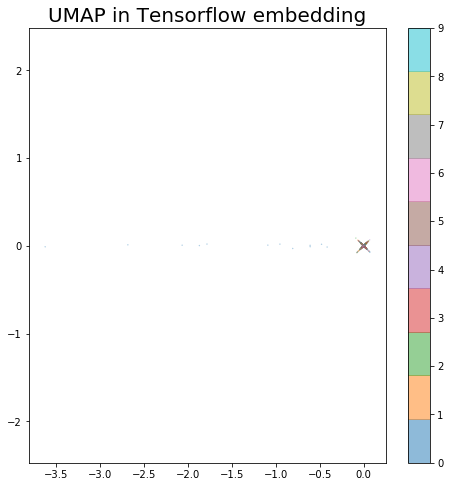

In [192]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [ ]:
plt.plot(model._history.history['loss'])